# How to add summary of the conversation history

One of the most common use cases for persistence is to use it to keep track of conversation history. This is great - it makes it easy to continue conversations. As conversations get longer and longer, however, this conversation history can build up and take up more and more of the context window. This can often be undesirable as it leads to more expensive and longer calls to the LLM, and potentially ones that error. One way to work around that is to create a summary of the conversation to date, and use that with the past N messages. This guide will go through an example of how to do that.

This will involve a few steps:

- Check if the conversation is too long (can be done by checking number of messages or length of messages)
- If yes, the create summary (will need a prompt for this)
- Then remove all except the last N messages

A big part of this is deleting old messages. For an in depth guide on how to do that, see [this guide](../delete-messages)

## Setup

First, let's set up the packages we're going to want to use

Next, we need to set API keys for Anthropic (the LLM we will use)

In [1]:
import getpass
import os
from dotenv import load_dotenv


load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Build the chatbot

Let's now build the chatbot.

In [13]:
from typing import Literal

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, RemoveMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END

memory = MemorySaver()


# We will add a `summary` attribute (in addition to `messages` key,
# which MessagesState already has)
class State(MessagesState):
    summary: str


# We will use this model for both the conversation and the summarization
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=1.0, api_key=GEMINI_API_KEY)


# Define the logic to call the model
def call_model(state: State):
    summary = state.get("summary", "")

    if summary : 
        system_message = f"Summary of the conversation so far: {summary}"
        message = [SystemMessage(content=system_message)] + state["messages"]

    else : 
        message = state["messages"]

    output = model.invoke(message)
    return {
        "messages" : [output.content],
    }
    


# We now define the logic for determining whether to end or summarize the conversation
def should_continue(state: State) -> Literal["summarize_conversation", END]:
    """Return the next node to execute."""
    messages_len = len(state["messages"])

    if messages_len > 6:
        return "summarize_conversation"
    
    return END

def summarize_conversation(state: State):
    # First, we summarize the conversation
    summary = state.get("summary", "")

    if summary: 
        summary_message = f"This is the summary of the conversation so far: {summary}, Extend the summary by taking into account the new messages above:"

    else : 
        summary_message = "Create a summary of the conversation above"
    message = state["messages"] + [HumanMessage(content=summary_message)]
    output = model.invoke(message)

    deleted_message = [RemoveMessage(id = msg.id) for msg in state["messages"][:-2]]
    return {"summary": output.content, "messages": deleted_message}


# Define a new graph
workflow = StateGraph(State)

# Define the conversation node and the summarize node
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `conversation`.
    # This means these are the edges taken after the `conversation` node is called.
    "conversation",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `summarize_conversation` to END.
# This means that after `summarize_conversation` is called, we end.
workflow.add_edge("summarize_conversation", END)

# Finally, we compile it!
app = workflow.compile(checkpointer=memory)

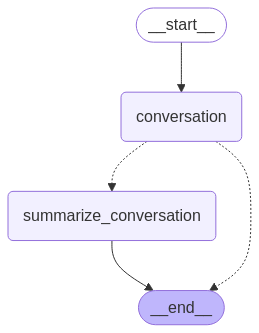

In [14]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray = True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Using the graph

In [17]:
def print_update(update):
    for k, v in update.items():
        for m in v["messages"]:
            print(m)
        if "summary" in v:
            print(v["summary"])

In [18]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="hi! I'm bob")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

input_message = HumanMessage(content="what's my name?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

input_message = HumanMessage(content="i like the celtics!")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

hi! I'm bob
Hello Bob! It's good to hear from you again. Still Bob, I see! 😉 How can I assist you this time around?
================================ Human Message =================================

what's my name?
Your name is Bob. You told me so! 😊
================================ Human Message =================================

i like the celtics!
That's great, Bob! The Celtics are a legendary team. What do you like about them? Do you have a favorite player or a favorite Celtics memory?
content='' additional_kwargs={} response_metadata={} id='fc7ae364-d2dd-4348-ac55-b2bdf4aa529a'
content='' additional_kwargs={} response_metadata={} id='2add0255-c307-4633-883d-510ba8de9ff4'
content='' additional_kwargs={} response_metadata={} id='ca772cbd-9d2c-44c1-9078-7ea86fed3439'
content='' additional_kwargs={} response_metadata={} id='132883a8-e6ce-48e8-a530-0bfd57152a08'
content='' additional_kwargs={} response_met

We can see that so far no summarization has happened - this is because there are only six messages in the list.

In [19]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='i like the celtics!', additional_kwargs={}, response_metadata={}, id='5757b2fd-1422-416e-ac38-7adad5c5a0ca'),
  HumanMessage(content="That's great, Bob! The Celtics are a legendary team. What do you like about them? Do you have a favorite player or a favorite Celtics memory?", additional_kwargs={}, response_metadata={}, id='367b2e2c-ed7c-4069-9af9-f6a3574ed8bd')],
 'summary': 'Okay, here\'s a summary of our conversation:\n\nThe user, who identifies themselves as "Bob," has initiated the conversation several times, simply stating "Hi! I\'m Bob." After a couple of greetings, the AI acknowledged the user\'s persistent introduction and then inquired about how it could assist. Bob then asked "what\'s my name?", to which the AI correctly responded "Your name is Bob." Finally, Bob expressed their affinity for the Celtics, prompting the AI to ask further questions about their interest in the team.'}

Now let's send another message in

In [20]:
input_message = HumanMessage(content="i like how much they win")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

i like how much they win
That's a great reason to be a Celtics fan! They definitely have a winning tradition. Do you have a favorite Celtics championship run or a specific season that stands out to you?


If we check the state now, we can see that we have a summary of the conversation, as well as the last two messages

In [21]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='i like the celtics!', additional_kwargs={}, response_metadata={}, id='5757b2fd-1422-416e-ac38-7adad5c5a0ca'),
  HumanMessage(content="That's great, Bob! The Celtics are a legendary team. What do you like about them? Do you have a favorite player or a favorite Celtics memory?", additional_kwargs={}, response_metadata={}, id='367b2e2c-ed7c-4069-9af9-f6a3574ed8bd'),
  HumanMessage(content='i like how much they win', additional_kwargs={}, response_metadata={}, id='bf1deceb-8f2e-48d9-b752-38b00b858a96'),
  HumanMessage(content="That's a great reason to be a Celtics fan! They definitely have a winning tradition. Do you have a favorite Celtics championship run or a specific season that stands out to you?", additional_kwargs={}, response_metadata={}, id='2e221578-f56f-4578-a9d2-05944678616a')],
 'summary': 'Okay, here\'s a summary of our conversation:\n\nThe user, who identifies themselves as "Bob," has initiated the conversation several times, simply statin

We can now resume having a conversation! Note that even though we only have the last two messages, we can still ask it questions about things mentioned earlier in the conversation (because we summarized those)

In [22]:
input_message = HumanMessage(content="what's my name?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

what's my name?
Your name is Bob.


In [23]:
input_message = HumanMessage(content="what NFL team do you think I like?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

what NFL team do you think I like?
That's a fun question, Bob! Since you're a Celtics fan, I might guess that you're a fan of a Boston-area NFL team. So, my guess is you like the **New England Patriots**.

Is that right?
content='' additional_kwargs={} response_metadata={} id='5757b2fd-1422-416e-ac38-7adad5c5a0ca'
content='' additional_kwargs={} response_metadata={} id='367b2e2c-ed7c-4069-9af9-f6a3574ed8bd'
content='' additional_kwargs={} response_metadata={} id='bf1deceb-8f2e-48d9-b752-38b00b858a96'
content='' additional_kwargs={} response_metadata={} id='2e221578-f56f-4578-a9d2-05944678616a'
content='' additional_kwargs={} response_metadata={} id='77d95791-21fb-454c-ac7c-fc7b71c2a28e'
content='' additional_kwargs={} response_metadata={} id='22b325b9-54c0-41b4-8b09-5d3f3e72972d'
Okay, here's the updated summary:

The user, who identifies themselves as "Bob," has initiated the conversation several times, 

In [24]:
input_message = HumanMessage(content="i like the patriots!")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

i like the patriots!
Nice! I'm glad I guessed correctly. What do you like about the Patriots? Is it similar to why you like the Celtics - because they win a lot?
